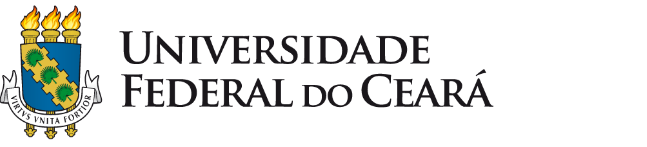

## Classificação de Imagens com o Dataset Médico (Pneumonia)

Disciplina: Sistema Distribuidos

Aluno: Ernesto Gurgel Valente Neto

Prof. Dr. Julio Anjos

## Objetivos

* Utilizar Deep Learning (CCN) para resolver problemas relacionados a visão computacional
* Aprender sobre o [Dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2)
* Usar um Serviço em Nuvem armazenamento em nuvem.
* Criar uma rede neural para desempenhar a classificação de imagen.
* Utilizar os pesos de uma rede pre-treinada com amplos parametros.
* Utilizar Data Augmentation para aumentar a precisão e robustes do modelo.
* Utilizar os Dados os pesos (iniciais) do modelo copilado em transferlearning para treinar uma rede capaz de classificar imagens de doenças pulmonares.

## Solução: Redes Neurais Convolucionais (CNNs) - Deep Learning

As Redes Neurais Convolucionais (CNNs) são especialmente boas para analisar dados visuais, como imagens médicas, devido às suas características e funcionalidades únicas. Aqui estão algumas justificativas para usar uma CNN em aplicações médicas:

1. **Reconhecimento de Padrões Espaciais:** CNNs são projetadas para reconhecer padrões espaciais em imagens através do uso de filtros e camadas de convolução. Isso é especialmente útil na análise de imagens médicas onde certos padrões ou características nas imagens (por exemplo, a forma e a textura de uma massa tumoral em uma imagem de ressonância magnética) são indicativos de uma condição médica.

2. **Invariância à Translação:** CNNs são invariantes à translação, o que significa que podem reconhecer um padrão independentemente de onde ele apareça na imagem. Isso é útil na análise de imagens médicas, pois a localização exata de uma anormalidade pode variar entre os pacientes.

3. **Redução de Dimensionalidade:** CNNs podem efetivamente reduzir a dimensionalidade dos dados, concentrando-se nas características mais importantes e ignorando as menos importantes. Isso é especialmente útil ao lidar com imagens médicas de alta resolução que podem ter uma alta dimensionalidade.

4. **Desempenho Superior:** Em muitos casos, CNNs demonstraram desempenho superior em comparação com outras técnicas de aprendizado de máquina na classificação de imagens e detecção de objetos. Na medicina, isso pode se traduzir em diagnósticos mais precisos e previsões de prognósticos.

5. **Automatização da extração de características:** Diferentemente dos métodos tradicionais de visão computacional, as CNNs aprendem automaticamente as características a partir dos dados de treinamento. Isso elimina a necessidade de engenharia manual de características, que pode ser demorada e requer conhecimento de especialistas.

Por estas razões, as CNNs têm sido amplamente utilizadas em diversas aplicações de imagem médica, como detecção de câncer, análise de imagens de ressonância magnética, ultrassom, tomografia computadorizada e muito mais.

## Dataset Médico (Pneumologia)

 Conjunto de dados de imagens validadas de OCT e radiografia de tórax descritas e analisadas em "Classificação baseada em aprendizado profundo e encaminhamento de doenças humanas tratáveis". As imagens OCT são divididas em um conjunto de treinamento e um conjunto de teste de pacientes independentes. As imagens OCT são rotuladas como (doença)-(ID do paciente randomizado)-(número da imagem deste paciente) e divididas em 4 diretórios: CNV, DME, DRUSEN e NORMAL.


Reconhecimento
[Dataset](https://data.mendeley.com/datasets/rscbjbr9sj/2)

License: CC BY 4.0
[Citation](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

[DOI](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)


## GPU
Ativiação e Validação das GPU e Memoria adicional

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 29 19:28:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Carregando as bibliotecas (pyhton)

In [3]:
#Importação das bibliotecas
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import os
import seaborn as sns
import cv2
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Carregando dados de serviço da nuvem

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
main_path = "/content/drive/MyDrive/archive/chest_xray"

In [6]:
all_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg")) + \
             glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg")) + \
             glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))

all_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg")) + \
                glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg")) + \
                glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))


Este código está criando três DataFrames do pandas (**df_train, df_test e df_valid**)

a partir das listas de imagens de treinamento, teste e validação que foram previamente definidas.

Cada DataFrame tem duas colunas:

* A coluna 'class' indica a classe da imagem. As imagens são rotuladas como
* 'Normal' ou 'Pneumonia'. A expressão `['Normal'] * len(train_normal)` cria uma lista que contém a string 'Normal' repetida o número de vezes igual ao tamanho de `train_normal`, que é o número de imagens normais no conjunto de treinamento. O mesmo é feito para a classe 'Pneumonia' com `['Pneumonia'] * len(train_pneumonia)`. As duas listas são então concatenadas juntas com o operador `+`, resultando em uma lista que tem a string 'Normal' para cada imagem normal e a string 'Pneumonia' para cada imagem com pneumonia.
*  A coluna 'image' contém os caminhos para as imagens. Similarmente à coluna 'class', os caminhos para as imagens normais e de pneumonia são concatenados juntos para formar uma única lista.

In [7]:
df_all = pd.DataFrame({
    'class': ['Normal'] * len(all_normal) + ['Pneumonia'] * len(all_pneumonia),
    'image': all_normal + all_pneumonia
})

Separando os dataset em conjuntos de dados de treino e teste

In [8]:
#Embaralhamento do dataset antes da divisão
df_all = df_all.sample(frac=1).reset_index(drop=True)

# Primeiro, dividimos o conjunto de dados em treinamento (80%) e teste (20%)
df_train, df_test = train_test_split(df_all, test_size=0.2, stratify=df_all['class'], random_state=42)

# Então dividimos o conjunto de treinamento em treinamento (80%) e validação (20%)
df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train['class'], random_state=42)

# Redefinindo o índice para poder validar os dados divididos
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Explorando os dados do MÉDICOS

O método shape retorna uma tupla representando as dimensões do DataFrame. A primeira entrada da tupla é o **número de linhas** e a **segunda é o número de colunas**.

* df_train.shape retorna o formato do DataFrame de treinamento, que contém as imagens e rótulos que serão usados para treinar o modelo.
* df_test.shape retorna o formato do DataFrame de teste, que contém as imagens e rótulos que serão usados para avaliar a performance do modelo depois que ele foi treinado.
* df_valid.shape retorna o formato do DataFrame de validação, que contém as imagens e rótulos que podem ser usados para ajustar os parâmetros do modelo durante o treinamento (embora a maneira como esses conjuntos de dados são usados possa variar dependendo da abordagem específica de modelagem usada).

In [9]:
print("data frame:\n", pd.concat([df_all.head(5), df_all.tail(5)]))

data frame:
           class                                              image
0        Normal  /content/drive/MyDrive/archive/chest_xray/trai...
1     Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
2        Normal  /content/drive/MyDrive/archive/chest_xray/trai...
3        Normal  /content/drive/MyDrive/archive/chest_xray/trai...
4     Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5851  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5852  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5853  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5854  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...
5855  Pneumonia  /content/drive/MyDrive/archive/chest_xray/trai...


In [10]:
print("df_train: ", df_train.shape)
print("df_test: ", df_test.shape)
print("df_valid: ", df_valid.shape)

df_train:  (3747, 2)
df_test:  (1172, 2)
df_valid:  (937, 2)


A função dtypes em pandas retorna uma série com o tipo de dado de cada coluna. O índice da série é o nome da coluna.

In [11]:
print("df_train", df_train.dtypes)
print("\n df_test:\n", df_test.dtypes)
print("\ndf_valid:\n", df_valid.dtypes)

df_train class    object
image    object
dtype: object

 df_test:
 class    object
image    object
dtype: object

df_valid:
 class    object
image    object
dtype: object


In [12]:
df_all

,class,image
0,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
1,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
2,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
3,Normal,/content/drive/MyDrive/archive/chest_xray/trai...
4,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
...,...,...
5851,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5852,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5853,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...
5854,Pneumonia,/content/drive/MyDrive/archive/chest_xray/trai...


## Explorando os dados do médicos / Definição de funções de plot das imagens

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens.

def plot_images(df, start_index, num_images):


*   df = é qual o dataframe será passado plotagem.
*   start_index = é a posição inicial do array.
*   num_images = é quantidade de imagens que serão plotadas








In [13]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
def plot_images(df, start_index, num_images):
    fig = plt.figure(figsize=(10, 10))
    if start_index + num_images > len(df):
        num_images = len(df) - start_index
    for i in range(num_images):
        image_path = df['image'][start_index + i]
        image_class = df['class'][start_index + i] #Pegando a classe da imagem
        try:
            image = Image.open(image_path)
            ax = fig.add_subplot(num_images, 1, i+1)
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Image {start_index + i}, Class: {image_class}')  #Imprimindo o titulo da classe da imagem
            ax.axis('off')
        #Excessão e tratamento de excessão em um acesso invalido.
        except (IOError, OSError) as e:
            print(f"Erro ao carregar imagem {start_index + i}: {e}")

    plt.tight_layout()
    plt.show()

### Analise das imagens médicas da classe "Normal"

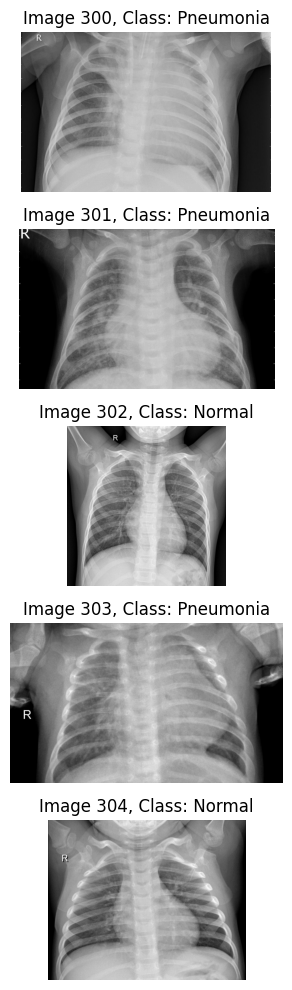

In [14]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_all, start_index=300, num_images=5)

### Analise das imagens médicas da classe "Pneumonia"

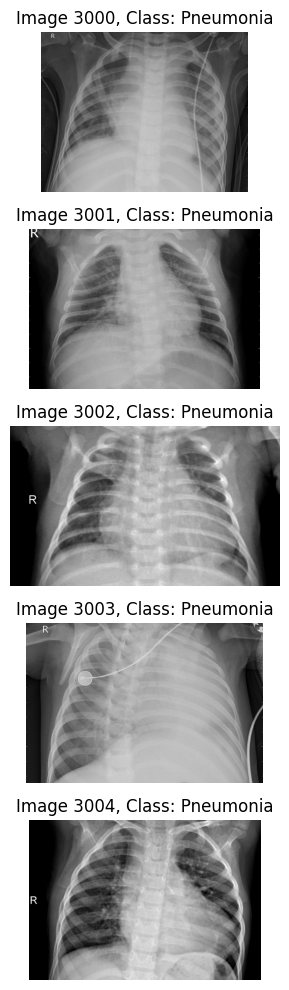

In [15]:
#Plot o plot_images(DATA FRAME PARA PRINT, INDEX XDO DATA FRASE, QTD IMAGEM PARA PLOT)
plot_images(df_all, start_index=3000, num_images=5)

### Explorando os dados do médicos / Definição de funções de distribuição

As especificações a seguir representam o uso da função (plot_images) ao qual imprime imagens. A função def plot_class_distribution(df):


*   Apresenta  a a distribuição do plot_class_distribution("DATA FRAME SELECIONADO")

In [16]:
def plot_class_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='class')
    plt.title('Distribuição das Classes')
    plt.show()

### Dataframe de treinamento

Analise da distribuição dos dados de treinamento das classes:

*   Normal; e
*   Pneumonia;

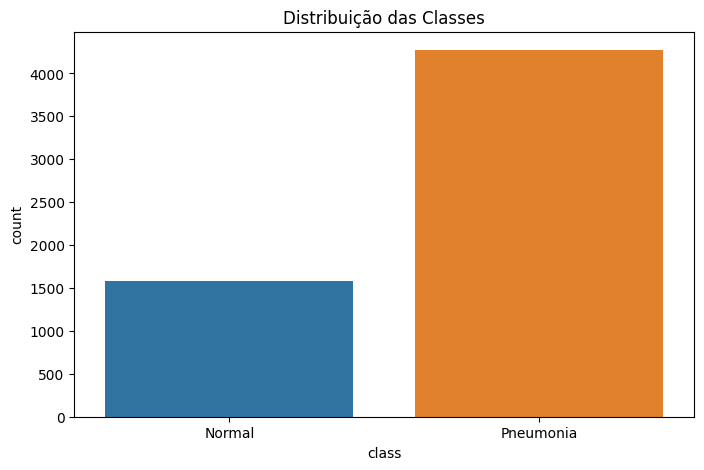

In [17]:
plot_class_distribution(df_all)

### Dataframe de Validação

Analise da distribuição dos dados de validação das classes:

*   Normal; e
*   Pneumonia;



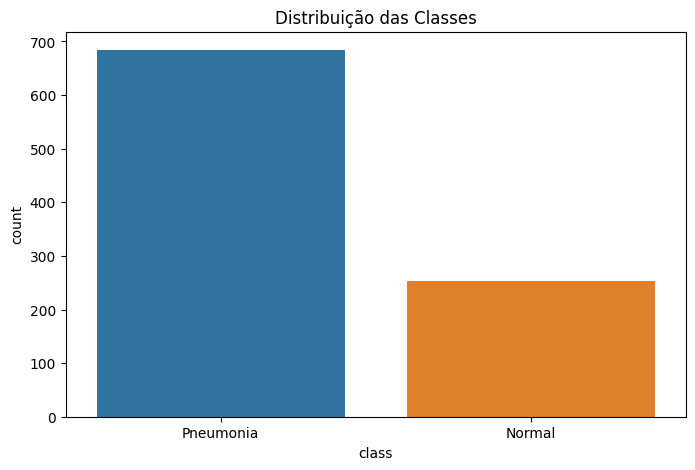

In [18]:
plot_class_distribution(df_valid)

### Dataframe de Teste

Analise da distribuição dos dados de teste das classes:

*   Normal; e
*   Pneumonia;



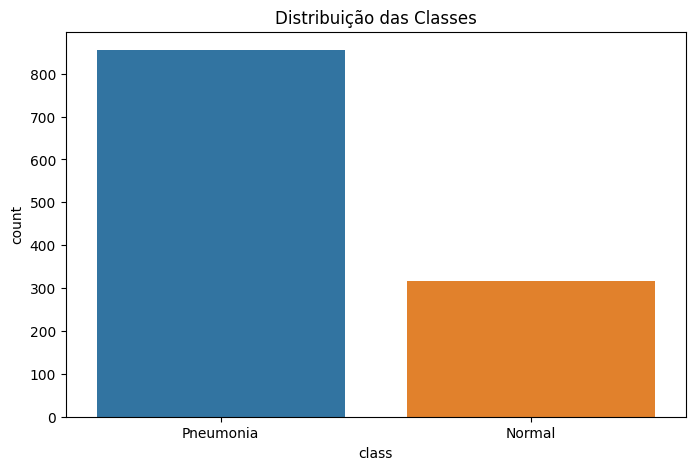

In [19]:
plot_class_distribution(df_test)

# Preparação dos Dados para o Treinamento

A função preprocess(df) é definida para processar um DataFrame df. A variável global processed_images é usada para rastrear o número de imagens processadas.

1. Dentro da função preprocess(df), são criadas duas listas vazias, images e labels. A lista labels é preenchida com os valores da coluna 'class' do DataFrame. Além disso as imagens estão sendo convertidas em escala de cinza 'L'.

2. Em seguida, a função itera sobre cada linha do DataFrame. Para cada linha, ela lê a imagem do arquivo especificado na coluna 'image', redimensiona essa imagem para 224x224 pixels usando a função resize() do PIL e normaliza os valores dos pixels dividindo por 255. A imagem processada é adicionada à lista images.

3. O contador processed_images é incrementado e o progresso do pré-processamento é impresso.

Logo o DF realizando as operações de leitura das imagens do DataFrame, redimensionamento para 224x224 pixels, normalização dos valores dos pixels para a faixa de 0 a 1 e rastreamento do progresso do pré-processamento. Além disso, está criando uma matriz de rótulos com base na coluna 'class' do DataFrame.

In [20]:
# Contar o número total de imagens
total_images = len(df_train) + len(df_valid) + len(df_test)
processed_images = 0

def preprocess(df):
    global processed_images
    images = []
    labels = df['class'].values  # 'class' é o nome da coluna de rótulos
    for _, row in df.iterrows():
        # Ler a imagem do arquivo, redimensionar para 224 x 224 e converter para escala de cinza
        image = Image.open(row['image']).convert("L")
        image = image.resize((224, 224))
        #Transformar em array 1 a 255 e normalizar
        image = np.array(image) / 255.0
        images.append(image)

        # Atualizar o contador de imagens processadas e imprimir o progresso
        processed_images += 1
        print(f'Progresso do pré-processamento: {processed_images / total_images * 100:.2f}%')

    return np.array(images), np.array(labels)

### Transformação dos dados

In [21]:
train_images, train_labels = preprocess(df_train)

Progresso do pré-processamento: 0.02%
Progresso do pré-processamento: 0.03%
Progresso do pré-processamento: 0.05%
Progresso do pré-processamento: 0.07%
Progresso do pré-processamento: 0.09%
Progresso do pré-processamento: 0.10%
Progresso do pré-processamento: 0.12%
Progresso do pré-processamento: 0.14%
Progresso do pré-processamento: 0.15%
Progresso do pré-processamento: 0.17%
Progresso do pré-processamento: 0.19%
Progresso do pré-processamento: 0.20%
Progresso do pré-processamento: 0.22%
Progresso do pré-processamento: 0.24%
Progresso do pré-processamento: 0.26%
Progresso do pré-processamento: 0.27%
Progresso do pré-processamento: 0.29%
Progresso do pré-processamento: 0.31%
Progresso do pré-processamento: 0.32%
Progresso do pré-processamento: 0.34%
Progresso do pré-processamento: 0.36%
Progresso do pré-processamento: 0.38%
Progresso do pré-processamento: 0.39%
Progresso do pré-processamento: 0.41%
Progresso do pré-processamento: 0.43%
Progresso do pré-processamento: 0.44%
Progresso do

In [22]:
valid_images, valid_labels = preprocess(df_valid)

Progresso do pré-processamento: 64.00%
Progresso do pré-processamento: 64.02%
Progresso do pré-processamento: 64.04%
Progresso do pré-processamento: 64.05%
Progresso do pré-processamento: 64.07%
Progresso do pré-processamento: 64.09%
Progresso do pré-processamento: 64.11%
Progresso do pré-processamento: 64.12%
Progresso do pré-processamento: 64.14%
Progresso do pré-processamento: 64.16%
Progresso do pré-processamento: 64.17%
Progresso do pré-processamento: 64.19%
Progresso do pré-processamento: 64.21%
Progresso do pré-processamento: 64.22%
Progresso do pré-processamento: 64.24%
Progresso do pré-processamento: 64.26%
Progresso do pré-processamento: 64.28%
Progresso do pré-processamento: 64.29%
Progresso do pré-processamento: 64.31%
Progresso do pré-processamento: 64.33%
Progresso do pré-processamento: 64.34%
Progresso do pré-processamento: 64.36%
Progresso do pré-processamento: 64.38%
Progresso do pré-processamento: 64.40%
Progresso do pré-processamento: 64.41%
Progresso do pré-processa

In [23]:
test_images, test_labels = preprocess(df_test)

Progresso do pré-processamento: 80.00%
Progresso do pré-processamento: 80.02%
Progresso do pré-processamento: 80.04%
Progresso do pré-processamento: 80.05%
Progresso do pré-processamento: 80.07%
Progresso do pré-processamento: 80.09%
Progresso do pré-processamento: 80.11%
Progresso do pré-processamento: 80.12%
Progresso do pré-processamento: 80.14%
Progresso do pré-processamento: 80.16%
Progresso do pré-processamento: 80.17%
Progresso do pré-processamento: 80.19%
Progresso do pré-processamento: 80.21%
Progresso do pré-processamento: 80.23%
Progresso do pré-processamento: 80.24%
Progresso do pré-processamento: 80.26%
Progresso do pré-processamento: 80.28%
Progresso do pré-processamento: 80.29%
Progresso do pré-processamento: 80.31%
Progresso do pré-processamento: 80.33%
Progresso do pré-processamento: 80.34%
Progresso do pré-processamento: 80.36%
Progresso do pré-processamento: 80.38%
Progresso do pré-processamento: 80.40%
Progresso do pré-processamento: 80.41%
Progresso do pré-processa

### Validação da transformação

Nessa etapa verificamos se os dataframes de treinamento e teste foram corretamente transformados.


In [24]:
# Verificando o shape do conjunto de treinamento
print("Shape do conjunto de treinamento:", train_images.shape)

Shape do conjunto de treinamento: (3747, 224, 224)


In [25]:
# Verificando o primeiro elemento do conjunto de treinamento
print("Primeiro elemento do conjunto de treinamento:\n", train_images[0])

Primeiro elemento do conjunto de treinamento:
 [[0.3254902  0.34117647 0.34509804 ... 0.13333333 0.12941176 0.07058824]
 [0.32941176 0.34509804 0.34509804 ... 0.13333333 0.1254902  0.07058824]
 [0.34901961 0.35294118 0.35294118 ... 0.12156863 0.12156863 0.07058824]
 ...
 [0.02745098 0.03137255 0.02352941 ... 0.         0.         0.        ]
 [0.02745098 0.03137255 0.02352941 ... 0.         0.         0.        ]
 [0.02745098 0.02745098 0.02352941 ... 0.         0.         0.        ]]


In [26]:
# Verificando o tipo dos dados no conjunto de treinamento
print("Tipo de dados no conjunto de treinamento:", train_images.dtype)

Tipo de dados no conjunto de treinamento: float64


In [27]:
# Verificando o valor mínimo e máximo no conjunto de treinamento
print("Valor mínimo no conjunto de treinamento:", train_images.min())
print("Valor máximo no conjunto de treinamento:", train_images.max())

Valor mínimo no conjunto de treinamento: 0.0
Valor máximo no conjunto de treinamento: 1.0


## Encodificação das Labels para classificação

In [28]:
# Verificando das labels
print("Print da da class (Labels):",train_labels[0:9])

Print da da class (Labels): ['Normal' 'Pneumonia' 'Normal' 'Pneumonia' 'Normal' 'Pneumonia'
 'Pneumonia' 'Normal' 'Pneumonia']


In [29]:
# Primeiro, convertemos as strings de classificação para inteiros
encoder = LabelEncoder()

train_labels = encoder.fit_transform(train_labels)
valid_labels = encoder.transform(valid_labels)
test_labels = encoder.transform(test_labels)

# Em seguida, codificamos os inteiros em one-hot
# Logo teremos dois rótulos: 0 (Normal) e 1 (Pneumonia).
#Dessa forma obtendo dois rótulos binários: [1, 0] para Normal e [0, 1] para Pneumonia.
train_labels = to_categorical(train_labels)
valid_labels = to_categorical(valid_labels)
test_labels = to_categorical(test_labels)

Validação do Array Validação da Etapa de Encodificação das labels
* 0 para Normal; e
* 1 para Pneumonia;
* Validação Conforme Array **"y_train[0:9]"** na linha anterior.

In [30]:
train_labels[0:9]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

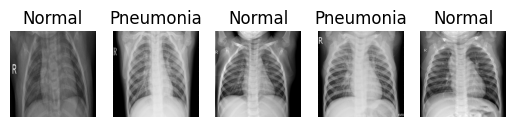

In [31]:
import matplotlib.pyplot as plt

# Vamos pegar as primeiras 5 imagens
first_5_images = train_images[:5]
first_5_labels = train_labels[:5]

# Define a lista de nomes de classes correspondentes aos rótulos
class_names = ["Normal", "Pneumonia"]

# Para cada imagem e rótulo
for i in range(5):
    # Cria uma subtrama para cada imagem
    plt.subplot(1,5,i+1)

    # Exiba a imagem
    plt.imshow(first_5_images[i], cmap='gray')

    # Adicione o rótulo como título
    label_index = np.argmax(first_5_labels[i])  # transforma one-hot de volta para inteiro
    plt.title(class_names[label_index])  # usa o rótulo para pegar o nome da classe

    # Remova os eixos
    plt.axis('off')

# Exiba a figura completa
plt.show()

In [32]:
# Convertendo o formato one-hot, valores inteiros
train_labels = np.argmax(train_labels, axis=-1)
valid_labels = np.argmax(valid_labels, axis=-1)

## Importando Modelo Pre-Treinado

Carregar a arquitetura do modelo VGG16 com pesos pré-treinados no ImageNet

* Normalmente estas redes possam ser um bom ponto de partida, embora elas não foram especificamente projetadas para a tarefa de classificar doenças pulmonares.
* Os modelos pré-treinados possam acelerar o processo de treinamento e muitas vezes levar a melhores resultados, embora eles não sejam uma solução garantida para todas as tarefas e podem não sempre levar ao melhor desempenho possível.

In [33]:
#reset da sessão e do modelo
tf.keras.backend.clear_session()

In [34]:
# Carregando o base_model, importando do imagenet os pessos
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelando as camadas da rede pré-treinada
for layer in base_model.layers:
    layer.trainable = False

# Estabelecendo nova camada totalmente conectada
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#Copilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [35]:
# Define data augmentation
datagen = ImageDataGenerator(
    #Dessa forma, quando usamos rescale=1./255 estamos basicamente fazendo uma pré-processamento para normalizar nossas imagens
    #antes de alimentá-las para o treinamento da rede neural.
    rescale=1./255,
    #As imagens de raios-X e tomografia computadorizada do tórax podem variar com base em fatores como o ângulo da imagem ou a posição do paciente.
    #Ainda algo também pode ser visto nas fotos, porém valores conservadores devem ser adotados para tornar o modelo mais robusto e evitar
    #Confundir o modelo
    shear_range=0.1,
    #Improvavel que rotação de raio-X de pulmão seja diferente de zero. Pode se tentar ainda algo conservador como 5 a 10.
    # Porém é possivel ver nas imagens que existe uma variação do angulo do pulmão e não esta perfeitamente alinhado no eixo principal
    rotation_range=0.1,
    #Util testar visto que pode ser tirado o raio-x de diferentes distancias. E não existe uma normativa global a que distancia deve ser tirado o raio-x do paciente.
    #Apenas a distancia do tecnico é referenciada como recomendado. Logo a posição e distancia relativa do paciente pode ser diferente em diferentes locais
    #De coleta.
    zoom_range=0.1,
    #A localização do pulmão na imagem variar, mas em um contexto médico,a posição do pulmão provavelmente é bastante padronizada.
    #Mudanças bruscas podem alterar drasticamente o modelo, sugerivel uma abordagem mais conservadora.
    width_shift_range=0.02,
    height_shift_range=0.02,
    #Pode ser util pela qualidade dos pulmões representarem dois horizontalmente e doenças e estados normais poderem ser melhor representados
    #De maneira espelhada na horizontal.
    horizontal_flip=True,
      #Essa opção é melhor desativada, confundiria o modelo um pulmão invertido
    vertical_flip=False
)

# Definição dos geradores de dados
#Treinamento
ds_train = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)
#Validação
ds_val = datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)
#Teste
ds_test = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1
)

Found 3747 validated image filenames belonging to 2 classes.
Found 937 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


In [36]:
#Definição do número de etapas de treinamento e validação com base no tamanho do dataset de treinamento e validação
nb_train_samples = len(ds_train)
nb_validation_samples = len(ds_val)

#Treinamento do modelo
history = model.fit(
    ds_train,
    steps_per_epoch=nb_train_samples,
    epochs=12,
    validation_data=ds_val,
    validation_steps=nb_validation_samples
)

#Salvando o modelo
model.save('model.h5')

Epoch 1/12
118/118 [==============================] - 89s 668ms/step - loss: 0.3218 - accuracy: 0.8997 - val_loss: 0.1798 - val_accuracy: 0.9360
Epoch 2/12
118/118 [==============================] - 78s 662ms/step - loss: 0.1578 - accuracy: 0.9448 - val_loss: 0.1412 - val_accuracy: 0.9488
Epoch 3/12
118/118 [==============================] - 78s 664ms/step - loss: 0.1153 - accuracy: 0.9576 - val_loss: 0.2140 - val_accuracy: 0.9125
Epoch 4/12
118/118 [==============================] - 78s 665ms/step - loss: 0.1238 - accuracy: 0.9536 - val_loss: 0.2225 - val_accuracy: 0.9296
Epoch 5/12
118/118 [==============================] - 78s 659ms/step - loss: 0.0893 - accuracy: 0.9650 - val_loss: 0.1017 - val_accuracy: 0.9616
Epoch 6/12
118/118 [==============================] - 79s 671ms/step - loss: 0.0790 - accuracy: 0.9706 - val_loss: 0.1813 - val_accuracy: 0.9349
Epoch 7/12
118/118 [==============================] - 80s 677ms/step - loss: 0.0939 - accuracy: 0.9672 - val_loss: 0.1041 - val_ac

In [37]:
# Obter a precisão (acurácia) final
accuracyFinal = history.history['accuracy'][-1]
print(f"Acurácia final do modelo: {accuracyFinal * 100:.2f}%")

Acurácia final do modelo: 97.84%


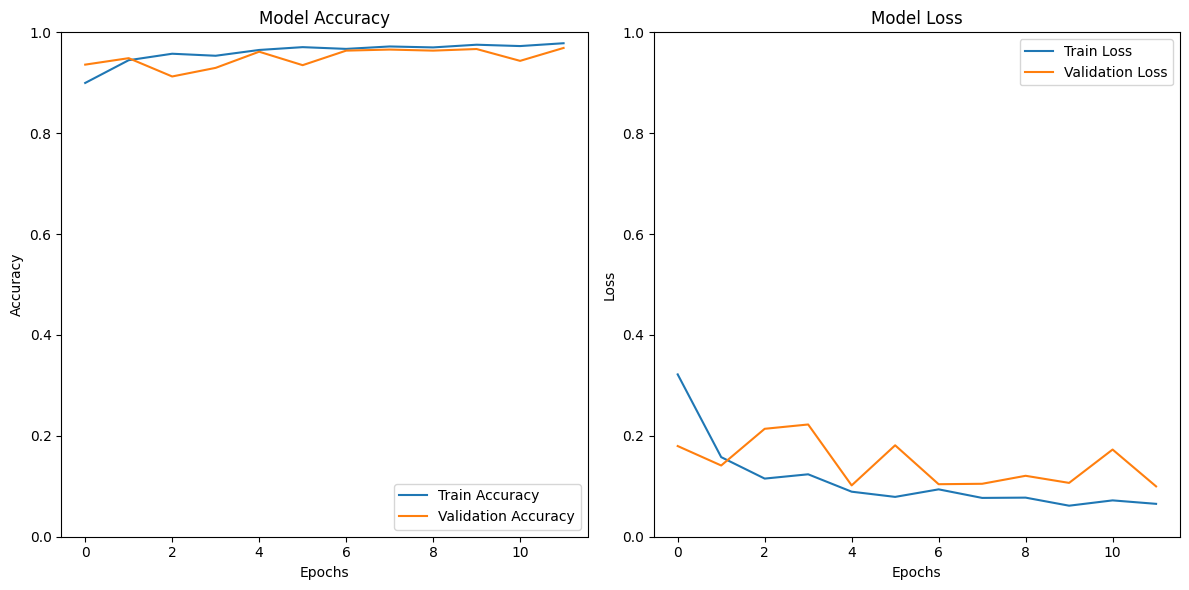

In [38]:
# Plota o histórico de acurácia
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim(0, 1)  # Define os limites do eixo y
plt.legend(loc='lower right')

# Plota o histórico de perda
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim(0, 1)  # Define os limites do eixo y para perda
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Data Augmentation & fine-tuning (Aumento de Dados e Ajuste Fino)

Com os dados de treinamento, validação e o modelo preparados, é hora de ajustar o modelo. Esse processo, também chamado de treinamento, adapta o modelo aos dados. Usamos o método `fit` do Keras, que requer:

* Dados de treinamento e respectivos rótulos
* Número de iterações completas no conjunto de treinamento (épocas)
* Dados de validação ou teste e seus rótulos

Ao executar o treinamento, o modelo aprenderá e ajustará sua forma para melhor representar os dados.

In [39]:
#Verificação do Modelo utilizado na transferencia de aprendizagem antes de realizar o ajuste fino
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Carregue o modelo gerado pela Tecnica Transfearlearning
model = load_model('model.h5')

# Garantindo que todas as celulas estivessem congeladas em todas as outras camadas
for layer in model.layers:
    layer.trainable = False

# Descogelando as últimas 4 camadas
for layer in model.layers[-4:]:
    layer.trainable = True

#Definindo o otimizador com uma pequena taxa de aprendizagem para melhor ajustar ao novo conjunto
optimizer = Adam(learning_rate=0.00001)

#Copilando o modelo
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
#Realizando o treinamento do ajuste fino
#O Conjunto de de dados (original) é relativamente pequeno então é preciso muito mais cuidado porque facilmente pode levar ao overfiting
#visto que o modelo salvo durante o transfearning teve um bom desempenho
history_fine = model.fit(
    ds_train,
    validation_data=ds_val,
    batch_size=16,  # O parâmetro batch_size para tentar suaviar o treinamento, buscando reduzir o overffiting ao introduzir maior variabilidade
    #Reduzindo o numero de epocas evitar um sobreajuste
    epochs=3
)

Epoch 1/3
118/118 [==============================] - 88s 675ms/step - loss: 0.0697 - accuracy: 0.9741 - val_loss: 0.1171 - val_accuracy: 0.9594
Epoch 2/3
118/118 [==============================] - 79s 669ms/step - loss: 0.0576 - accuracy: 0.9778 - val_loss: 0.1135 - val_accuracy: 0.9648
Epoch 3/3
118/118 [==============================] - 78s 664ms/step - loss: 0.0466 - accuracy: 0.9824 - val_loss: 0.0805 - val_accuracy: 0.9755


In [42]:
# Obter a precisão (acurácia) final
accuracyFinal = history.history['accuracy'][-1]
print(f"Acurácia final do modelo: {accuracyFinal * 100:.2f}%")

Acurácia final do modelo: 97.84%


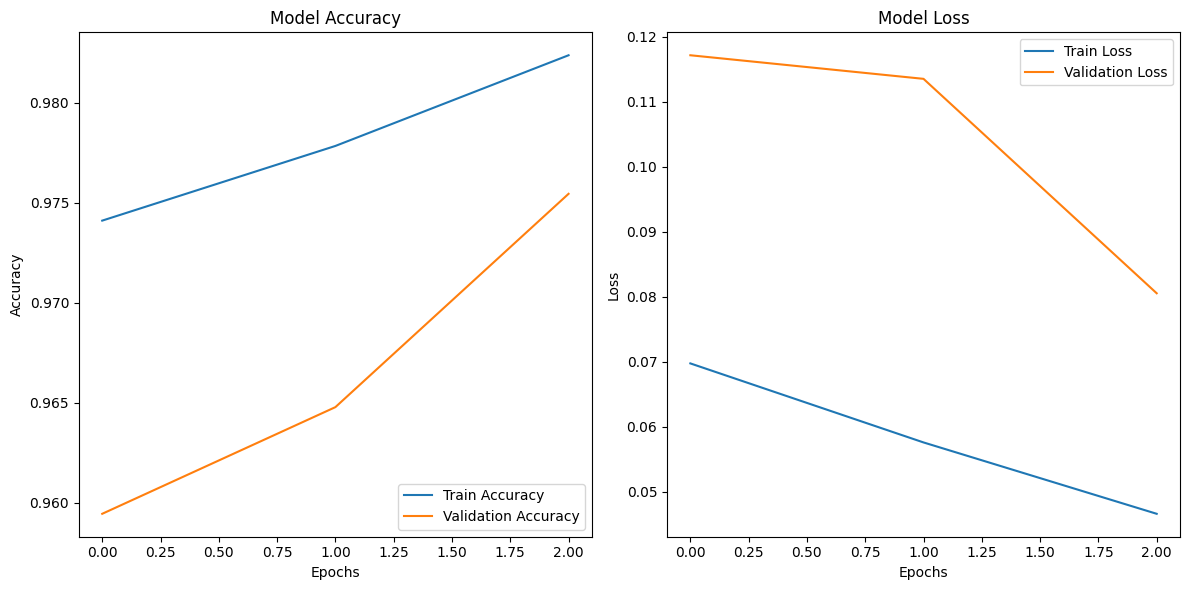

In [43]:
# Plota o histórico de acurácia
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')  # Changed to 'accuracy'
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')  # Changed to 'val_accuracy'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

# Plota o histórico de perda
plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Realizando as prediçoes

In [44]:
# Faça previsões no conjunto de testes
predictions = model.predict(ds_test)

# Converta as previsões para rótulos inteiros (0 ou 1)
predictions_int = (predictions > 0.5).astype(int).flatten()

# Converta os rótulos de teste para inteiros
test_labels_int = np.argmax(test_labels, axis=-1)

# Agora, use o inverse_transform para obter rótulos originais
predictions_orig = encoder.inverse_transform(predictions_int)
test_labels_orig = encoder.inverse_transform(test_labels_int)

# Imprimir as previsões e rótulos verdadeiros
for pred, true in zip(predictions_orig, test_labels_orig):
    print(f'Predição: {pred}, Atual: {true}')


1172/1172 [==============================] - 21s 17ms/step
Predição: Pneumonia, Atual: Pneumonia
Predição: Normal, Atual: Pneumonia
Predição: Normal, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Normal
Predição: Pneumonia, Atual: Normal
Predição: Normal, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Normal
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Normal, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Normal, Atual: Normal
Predição: Normal, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Normal, Atual: Normal
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Normal
Predição: Normal, Atual: Pneumonia
Predição: Pneumonia, Atual: Pneumonia
Predição: Pneumonia, Atual: Normal
Predição: Normal, Atual: Pneumonia
P

In [45]:
from sklearn.metrics import confusion_matrix

# As previsões para rótulos inteiros (0 ou 1)
predictions_int = (predictions > 0.5).astype(int).flatten()

# Os rótulos de teste para inteiros
test_labels_int = np.argmax(test_labels, axis=-1)

# A matriz de confusão
cm = confusion_matrix(test_labels_int, predictions_int)

# Os elementos da matriz de confusão:
TN, FP, FN, TP = cm.ravel()

# imprime o número de "verdadeiros positivos" (TP), que são os casos em que o modelo corretamente previu a classe positiva.
print(f'Verdadeiro Positivos: {TP}')
# imprime o número de "verdadeiros negativos" (TN), que são os casos em que o modelo corretamente previu a classe negativa.
print(f'Verdadeiro Negativo: {TN}')
# imprime o número de "falsos positivos" (FP), que são os casos em que o modelo incorretamente previu a classe positiva.
print(f'Falsos Positivos: {FP}')
# Isto imprime o número de "falsos negativos" (FN), que são os casos em que o modelo incorretamente previu a classe negativa.
print(f'Falsos Negativo: {FN}')

Verdadeiro Positivos: 634
Verdadeiro Negativo: 88
Falsos Positivos: 229
Falsos Negativo: 221


In [46]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6160409556313993
